In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter



# Algorithms
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
# preproceessing
from abpred.Transformers import FeaturesInteractions, SkewTransformer, ZeroThreshold
#from abpred.stacking_models import StackingAveragedModels
from sklearn.feature_selection import VarianceThreshold

from sklearn.metrics import mean_squared_error, r2_score ,make_scorer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.model_selection import RepeatedKFold, KFold,GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import MinMaxScaler

import joblib

In [2]:

#dataframe final
df_final = pd.read_csv("../data/abpred_train_2020_v2.csv",index_col=0)


pdb_names = df_final.index
features_names = df_final.drop('ddG',axis=1).columns
df_final.shape

(1832, 78)

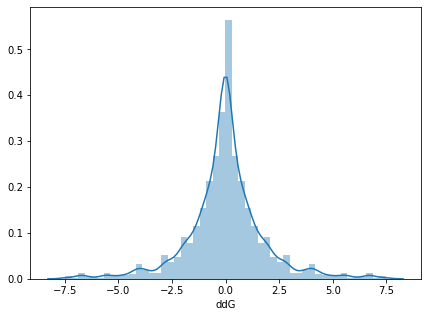

In [3]:

plt.subplots(figsize=(7, 5))
sns.distplot(df_final['ddG'],bins=None);
#plt.savefig("Train15_balanced.svg",dpi=300,bbox_inches="tight")

## Binarizing for stratified split

In [4]:
bins = np.histogram_bin_edges(df_final['ddG'], bins='rice')
#bins = np.linspace(df_final['ddG'].min(), df_final['ddG'].max(), 37)
y_binned = np.digitize(df_final['ddG'],bins)



In [5]:
counts = Counter(y_binned)
counts

Counter({17: 46,
         14: 264,
         13: 508,
         16: 93,
         18: 35,
         15: 147,
         19: 18,
         20: 24,
         12: 264,
         24: 9,
         22: 10,
         10: 93,
         21: 9,
         25: 3,
         23: 3,
         7: 18,
         9: 46,
         11: 147,
         6: 24,
         8: 35,
         26: 1,
         5: 9,
         2: 9,
         4: 10,
         1: 4,
         3: 3})

In [6]:
# merge group 26 with 25
y_binned[np.where(y_binned==26)] = 25

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_final.drop('ddG',axis=1), df_final['ddG'],stratify=y_binned,
                                                    test_size=0.2, random_state=13)


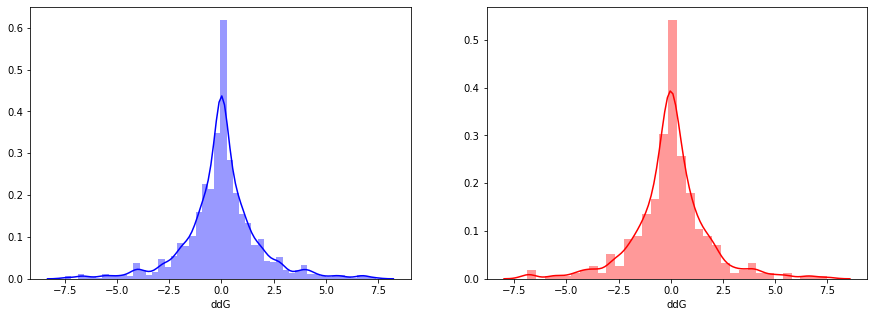

In [8]:
plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)

#f, ax = plt.subplots(figsize=(10, 7))
sns.distplot(y_train, color="blue", label="ddG_exp_train");

plt.subplot(1, 2, 2)
sns.distplot(y_test, color="red", label="ddG_exp_test");

#plt.savefig("Train_holdout_data2020.png",dpi=300,bbox_inches="tight")

In [9]:
# join train data for Exploratory analisis of training data
train = X_train.join(y_train)


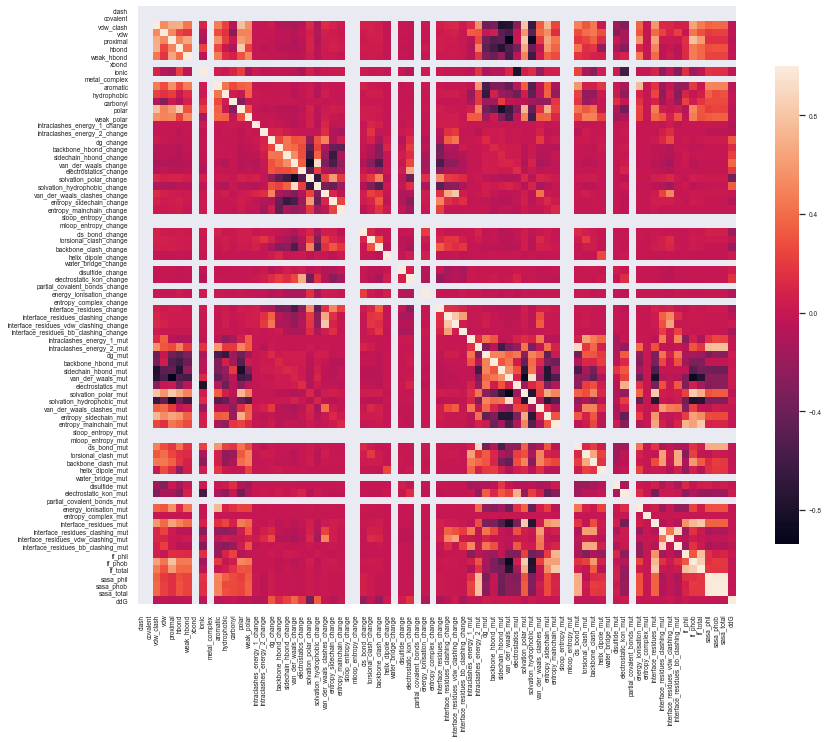

In [10]:
sns.set(font_scale=0.6)

#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(14, 11))
sns.heatmap(corrmat, square=True,cbar_kws={"shrink": .8});
#plt.savefig("Train15_initCorr.png",dpi=300,bbox_inches="tight")

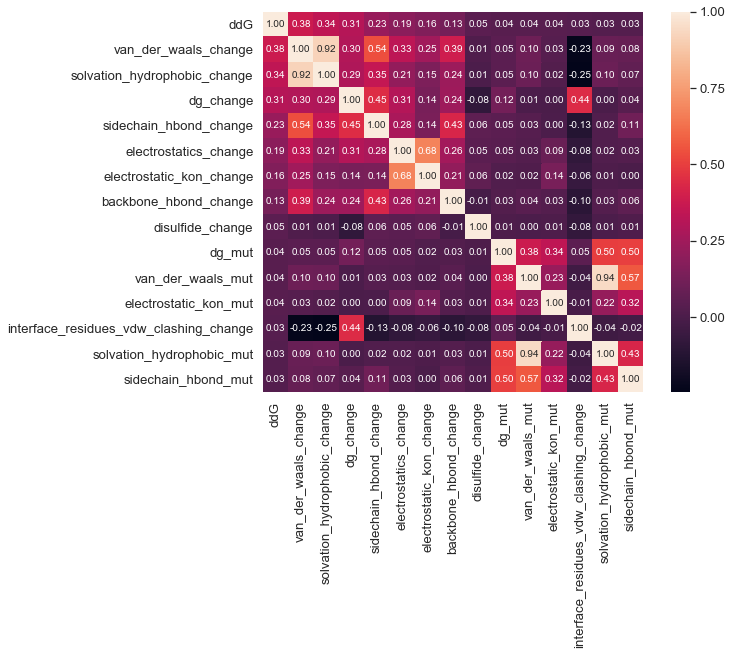

In [11]:
sns.set(font_scale=1.2)


#top 10. correlation matrix
k = 15 #number of variables for heatmap
cols = corrmat.nlargest(k, 'ddG')['ddG'].index
cm = np.corrcoef(train[cols].values.T)

f, ax = plt.subplots(figsize=(10, 7))
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values);
#plt.savefig("Train15_initCorrTOP15.png",dpi=300,bbox_inches="tight")

In [12]:
corrmat.nsmallest(k, 'ddG')['ddG']

solvation_polar_change                  -0.354275
backbone_clash_change                   -0.191576
cis_bond_change                         -0.184720
interface_residues_change               -0.127096
interface_residues_bb_clashing_change   -0.114560
intraclashes_energy_1_change            -0.088206
energy_ionisation_change                -0.086557
entropy_sidechain_change                -0.079962
intraclashes_energy_2_change            -0.046571
proximal                                -0.045279
interface_residues_clashing_change      -0.043615
polar                                   -0.043085
solvation_polar_mut                     -0.038757
vdw_clash                               -0.033884
aromatic                                -0.031226
Name: ddG, dtype: float64

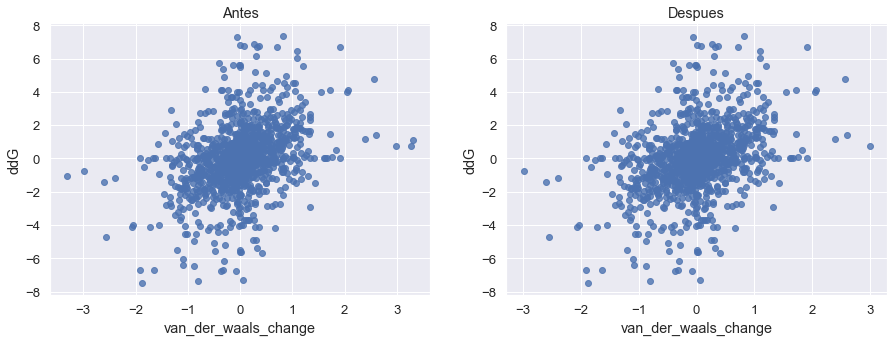

In [13]:
#sns.set(font_scale=1)

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['van_der_waals_change'], y=train['ddG'], fit_reg=False).set_title("Antes")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['van_der_waals_change'].abs()>3.)].index)
g = sns.regplot(x=train['van_der_waals_change'], y=train['ddG'], fit_reg=False).set_title("Despues")
#plt.savefig("Train15_outlierVDWchange.png",dpi=600,bbox_inches="tight")

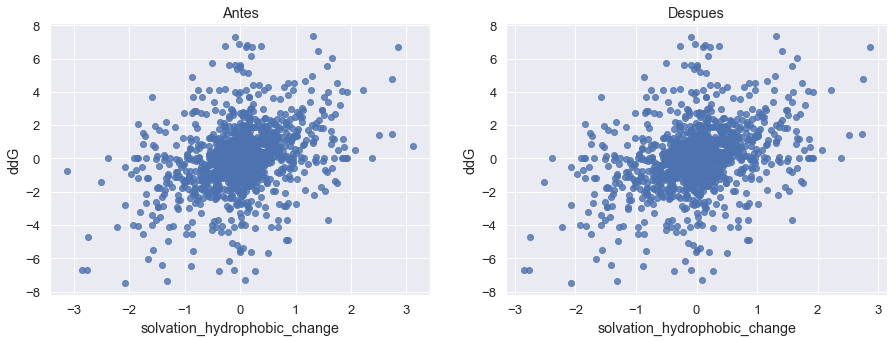

In [14]:

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['solvation_hydrophobic_change'], y=train['ddG'], fit_reg=False).set_title("Antes")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['solvation_hydrophobic_change'].abs()>3.)].index)
g = sns.regplot(x=train['solvation_hydrophobic_change'], y=train['ddG'], fit_reg=False).set_title("Despues")
#plt.savefig("Train15_outlierVDWchange.png",dpi=600,bbox_inches="tight")

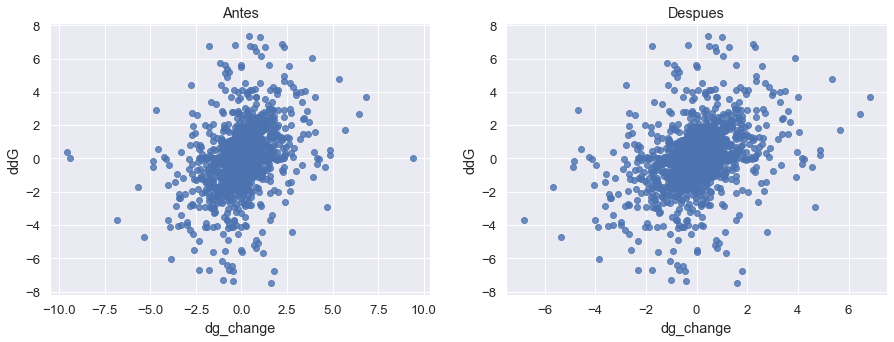

In [15]:

plt.subplots(figsize=(15, 5))

plt.subplot(1, 2, 1)
g = sns.regplot(x=train['dg_change'], y=train['ddG'], fit_reg=False).set_title("Antes")

# Delete outliers
plt.subplot(1, 2, 2)                                                                                
train = train.drop(train[(train['dg_change'].abs()>7)].index)
g = sns.regplot(x=train['dg_change'], y=train['ddG'], fit_reg=False).set_title("Despues")
#plt.savefig("Train15_outlierDgchange.png",dpi=600,bbox_inches="tight")

In [16]:
y_train = train['ddG']
X_train = train.drop('ddG',axis=1)

In [17]:
X_test.shape,X_train.shape

((367, 77), (1457, 77))

In [18]:
full_data = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

In [19]:
from scipy.stats import pearsonr

def pearson_r(x,y):
    result = pearsonr(x,y)[0]
    return result

scoring = {'r2': 'r2',
          'neg_mean_squared_error': 'neg_mean_squared_error',
          'pearson': make_scorer(pearson_r)}

In [20]:
# #### Crossvalidation strategy

# In[6]:

def cv_results(cv_object):
    # scores
    rmse_train_cv = np.sqrt(-cv_object["train_neg_mean_squared_error"])
    rmse_test_cv = np.sqrt(-cv_object["test_neg_mean_squared_error"])
    r2_train_cv = cv_object["train_r2"]
    r2_test_cv = cv_object["test_r2"]
    pearson_train_cv = eva_result['train_pearson']
    pearson_test_cv = eva_result['test_pearson']

    print("RMSE train CV: {:.4f} ({:.4f})".format(rmse_train_cv.mean(), rmse_train_cv.std()))
    print("RMSE test CV: {:.4f} ({:.4f})".format(rmse_test_cv.mean(), rmse_test_cv.std()))
    print('DIFF RMSE {}\n'.format(rmse_test_cv.mean() - rmse_train_cv.mean()))

    print("r2 train CV: {:.4f} ({:.4f})".format(r2_train_cv.mean(), r2_train_cv.std()))
    print("r2 test CV: {:.4f} ({:.4f})".format(r2_test_cv.mean(), r2_test_cv.std()))
    print('DIFF r2 {}\n'.format(r2_test_cv.mean() - r2_train_cv.mean()))
    
    print("pearsonr train CV: {:.4f} ({:.4f})".format(pearson_train_cv.mean(), pearson_train_cv.std()))
    print("pearsonr test CV: {:.4f} ({:.4f})".format(pearson_test_cv.mean(), pearson_test_cv.std()))
    print('DIFF pearsonr {}\n'.format(pearson_test_cv.mean() - pearson_test_cv.mean()))


def test_results(fitted_estimator, Xtest, Ytest):
    y_test_pred = fitted_estimator.predict(Xtest)
    # y_train_pred = fitted_estimator.predict(Xtrain)

    print("RMSE test: {}".format(np.round(np.sqrt(mean_squared_error(Ytest, y_test_pred)), 2)))

    print('r2 test', r2_score(Ytest, y_test_pred))
    # print('r2 train',r2_score(Ytrain,y_train_pred))

    print("Pearson corr test {:f}".format(np.corrcoef(y_test_pred, Ytest.ravel())[0][1]))


# Validation function
n_folds = 10
def evaluating(model, Xtrain, Ytarget):
    # kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(Xtrain)
    rkf = RepeatedKFold(n_splits=10, n_repeats=5, random_state=13)
    cvscore = cross_validate(model, Xtrain, Ytarget, scoring=["r2", "neg_mean_squared_error"],
                             cv=rkf, verbose=1, n_jobs=-1, return_train_score=True, return_estimator=True)
    return cvscore

def cv10_results(model, Xtrain, Ytarget):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(Xtrain.values)
    # rkf = RepeatedKFold(n_splits=10,n_repeats=10,random_state=13)
    cvscore = cross_validate(model, Xtrain, Ytarget, scoring=scoring,
                             cv=kf, verbose=1, n_jobs=-1, return_train_score=True, return_estimator=True)
    return cvscore

In [21]:
# preprocess pipeline steps
# steps pipeline
interactions = FeaturesInteractions(features1=range(15), feature2=20)
variance = VarianceThreshold(threshold=0.)
skewness = SkewTransformer(threshold=0.5)
zeroth = ZeroThreshold(threshold=90.)


In [22]:
from vecstack import StackingTransformer,stacking
#https://github.com/vecxoz/vecstack/blob/master/examples/04_sklearn_api_regression_pipeline.ipynb

In [89]:
#lasso model
lasso = make_pipeline(interactions,variance,skewness,zeroth,MinMaxScaler(),
                      Lasso(alpha=0.001,normalize=False,fit_intercept=True,random_state=1))
# svr polynomial kernel
svrP = make_pipeline(interactions,variance,skewness,zeroth,MinMaxScaler(),
                      SVR(C=1,degree=2,epsilon=0.3,gamma=0.3,kernel='poly'))

svrRBF = make_pipeline(interactions,variance,skewness,zeroth,MinMaxScaler(),
                      SVR(C=10,epsilon=0.5,gamma=0.4,kernel='rbf'))

gbt = make_pipeline(interactions,variance,skewness,zeroth,
                    GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=2, 
                                   loss='huber', random_state =5,subsample=0.6,alpha=0.8))

xgb = make_pipeline(interactions,variance,skewness,zeroth,
                   XGBRegressor(colsample_bytree=0.6, gamma=0,
                             learning_rate=0.07, max_depth=8, 
                             min_child_weight=20, n_estimators=1000,
                             reg_alpha=10, reg_lambda=10,
                             subsample=0.75,random_state =7, nthread=-1,objective='reg:squarederror'))

extra = make_pipeline(interactions,variance,skewness,zeroth,
                     ExtraTreesRegressor(n_estimators=100,max_depth=5,n_jobs=-1,random_state=13,min_samples_split=2))

In [90]:
estimators_L1 = [
    ('lasso', lasso),        
    ('gbt', gbt),        
    ('svrRBF', svrRBF),
    ('svrPoly', svrP),
]

In [91]:
stack = StackingTransformer(estimators=estimators_L1,   # base estimators
                            regression=True,            # regression task (if you need 
                                                        #     classification - set to False)
                            variant='A',                # oof for train set, predict test 
                                                        #     set in each fold and find mean
                            metric=mean_squared_error, # metric: callable
                            n_folds=10,                  # number of folds
                            shuffle=True,               # shuffle the data
                            random_state=13,             # ensure reproducibility
                            verbose=2)                  # print all info

In [92]:
#Initialize 2nd level estimator
#final_estimator = ExtraTreesRegressor(n_estimators=100,max_depth=5,n_jobs=-1,random_state=13,min_samples_split=2)
final_estimator = Lasso(alpha=0.00001,normalize=True,fit_intercept=False,random_state=1)


In [93]:
steps = [('stack', stack),
         ('final_estimator', final_estimator)]

# Init Pipeline
pipe = Pipeline(steps)
# Fit
pipe = pipe.fit(X_train, y_train)

task:         [regression]
metric:       [mean_squared_error]
variant:      [A]
n_estimators: [4]

estimator  0: [lasso: Pipeline]
    fold  0:  [2.61663999]
    fold  1:  [2.23171387]
    fold  2:  [2.14399948]
    fold  3:  [3.23879684]
    fold  4:  [3.74120651]
    fold  5:  [2.89244644]
    fold  6:  [1.52499701]
    fold  7:  [2.67958813]
    fold  8:  [2.17244578]
    fold  9:  [1.86710754]
    ----
    MEAN:     [2.51089416] + [0.62787641]

estimator  1: [gbt: Pipeline]
    fold  0:  [2.17288316]
    fold  1:  [1.98648123]
    fold  2:  [1.80513695]
    fold  3:  [2.83512680]
    fold  4:  [3.60220351]
    fold  5:  [2.55863464]
    fold  6:  [1.65187946]
    fold  7:  [2.66438676]
    fold  8:  [2.12661844]
    fold  9:  [1.63646915]
    ----
    MEAN:     [2.30398201] + [0.58577662]

estimator  2: [svrRBF: Pipeline]
    fold  0:  [2.32844549]
    fold  1:  [2.10390078]
    fold  2:  [1.69748716]
    fold  3:  [2.82815654]
    fold  4:  [3.47804520]
    fold  5:  [2.45877166]


In [87]:
eva_result = cv10_results(pipe,X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.5min finished


In [88]:
cv_results(eva_result)

RMSE train CV: 1.5081 (0.0163)
RMSE test CV: 1.5009 (0.1475)
DIFF RMSE -0.00713201487496673

r2 train CV: 0.3123 (0.0125)
r2 test CV: 0.3073 (0.0599)
DIFF r2 -0.00496601700471605

pearsonr train CV: 0.5587 (0.0113)
pearsonr test CV: 0.5640 (0.0520)
DIFF pearsonr 0.0



In [94]:
# Final prediction score
print('Final prediction score using Pipeline:')
# # Final prediction score
pipe.set_params(stack__verbose=0)
test_results(pipe,X_test,y_test)

Final prediction score using Pipeline:
RMSE test: 1.48
r2 test 0.3471352842113449
Pearson corr test 0.591407


In [71]:
final_model = pipe.fit(full_data, y_full)

In [76]:
# Save Pipeline
_ = joblib.dump(final_model, 'stack_lasso-lasso-gbt-svrRBF-svrPoly-2020.pkl')

# Model evaluation plots

In [67]:
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

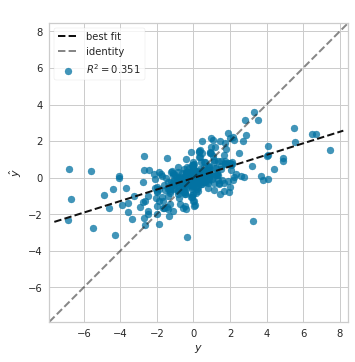

In [85]:
perror = PredictionError(pipe, title=" ")

perror.fit(X_train.values, y_train.values.ravel())  # Fit the training data to the visualizer
perror.score(X_test.values, y_test.values.ravel())  # Evaluate the model on the test data

perror.finalize()
plt.savefig("AbpredModel_predictionError_2020.png",dpi=300,bbox_inches="tight")

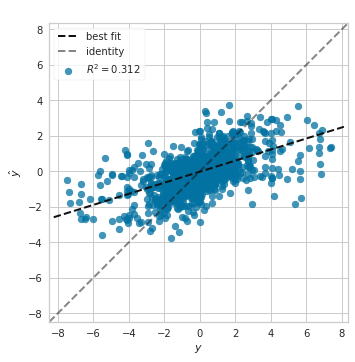

In [87]:
perror = PredictionError(pipe, title=' ')

perror.fit(X_train.values, y_train.values.ravel())  # Fit the training data to the visualizer
perror.score(X_train.values, y_train.values.ravel())  # Evaluate the model on the test data

perror.finalize()
plt.savefig("AbpredModel_TrainingError_2020.png",dpi=300,bbox_inches="tight")

Text(0, 0.5, 'Residuos')

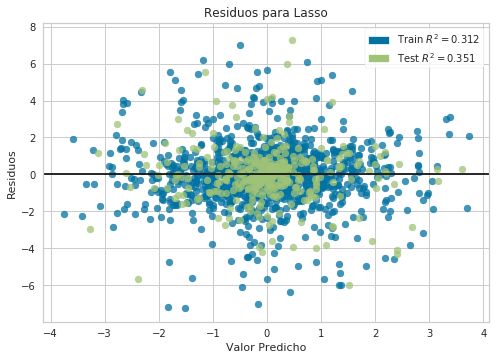

In [70]:
visualizer = ResidualsPlot(pipe,title='',hist=False)

visualizer.fit(X_train.values, y_train.values.ravel())  # Fit the training data to the model
visualizer.score(X_test.values, y_test.values.ravel())  # Evaluate the model on the test data

visualizer.finalize()
visualizer.ax.set_xlabel('Valor Predicho')
visualizer.ax.set_ylabel('Residuos')

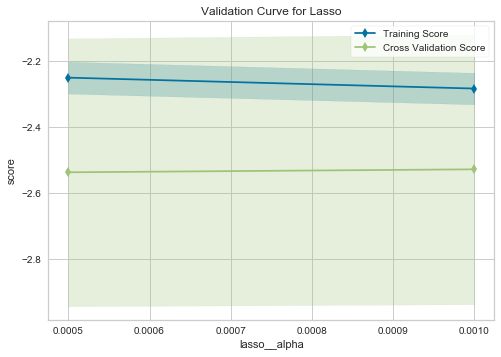

In [60]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve

#2)
pipeline1 = make_pipeline(interactions,variance,skewness,zeroth,MinMaxScaler(),
                      Lasso(alpha=0.001,normalize=False,fit_intercept=True,random_state=1))

# Extract the instances and target
viz = ValidationCurve(
    pipeline1, njobs=-1,param_name="lasso__alpha",
    param_range=[0.0005,0.001], cv=10, scoring="neg_mean_squared_error"
)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train.values, y_train.values)
viz.poof()

In [54]:
Lasso?

In [61]:
np.sqrt(-viz.test_scores_mean_),np.sqrt(viz.test_scores_std_)#,np.sqrt(-viz.train_scores_mean_),

(array([1.59299039, 1.59015393]), array([0.63640975, 0.63880053]))

In [26]:
np.sqrt(-viz.test_scores_mean_),np.sqrt(viz.test_scores_std_),np.sqrt(-viz.train_scores_mean_),

(array([1.5692763 , 1.54366564, 1.53553809, 1.51826681, 1.52265203,
        1.52251731, 1.52630053, 1.52853889]),
 array([0.73731114, 0.72662855, 0.70939285, 0.71105486, 0.66526872,
        0.69185629, 0.70990182, 0.71084155]),
 array([1.1669168 , 0.97979593, 0.84821432, 0.76982535, 0.72548976,
        0.69346233, 0.67386825, 0.66409126]))

In [67]:
GradientBoostingRegressor(n_estimators=500, learning_rate=0.05,
                                   max_depth=5, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=2, 
                                   loss='huber', random_state =5,subsample=0.6,alpha=0.8)

(array([1.60830225, 1.60591848, 1.60247956, 1.60065132, 1.59861372]),
 array([0.59132508, 0.59370854, 0.61576116, 0.64526548, 0.65636424]),
 array([1.51241258, 1.51447181, 1.5250123 , 1.54247801, 1.55545154]))

In [79]:


param_grid = {
    'gradientboostingregressor__max_depth': [5],
    'gradientboostingregressor__max_features': ['sqrt'],
    'gradientboostingregressor__min_samples_leaf': [13,15,17,20],
    'gradientboostingregressor__min_samples_split': [2],
    'gradientboostingregressor__n_estimators': [500],
    'gradientboostingregressor__subsample':[0.6],
    'gradientboostingregressor__learning_rate':[0.05],
    'gradientboostingregressor__loss':["huber"],
    'gradientboostingregressor__alpha':[0.7,0.8]}

model1 = GradientBoostingRegressor(random_state=13)
pipelineG = make_pipeline(interactions,variance,skewness,zeroth,model1)

kfC = KFold(10, shuffle=True, random_state=42)

# Instantiate the grid search model
grid1 = GridSearchCV(pipelineG, param_grid, verbose=5, n_jobs=-1,cv=kfC,scoring=['neg_mean_squared_error','r2'],
                        refit='neg_mean_squared_error',return_train_score=True)

grid1.fit(X_train.values, y_train.values)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done  66 out of  80 | elapsed:   34.3s remaining:    7.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   34.7s finished


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('featuresinteractions',
                                        FeaturesInteractions(feature2=20,
                                                             features1=range(0, 15))),
                                       ('variancethreshold',
                                        VarianceThreshold(threshold=0.0)),
                                       ('skewtransformer',
                                        SkewTransformer(threshold=0.5)),
                                       ('zerothreshold',
                                        ZeroThreshol...
                         'gradientboostingregressor__max_features': ['sqrt'],
                         'gradientboostingregressor__min_samples_leaf': [13, 15,
                                                                         17,


In [80]:
# index of best scores
rmse_bestCV_test_index = grid1.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid1.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid1.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid1.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid1.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid1.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid1.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid1.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid1.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid1.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid1.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid1.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('DIFF RMSE {}'.format(np.sqrt(-rmse_bestCV_test_score)-np.sqrt(-rmse_bestCV_train_score)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid1.best_params_)
y_test_pred = grid1.best_estimator_.predict(X_test.values)
y_train_pred = grid1.best_estimator_.predict(X_train.values)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test.values, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train.values, y_train_pred)), 2)))
print("pearson corr  test {:f}".format(np.corrcoef(y_test_pred,y_test.values.ravel())[0][1]))
print("pearson corr  train {:f}".format(np.corrcoef(y_train_pred,y_train.values.ravel())[0][1]))

print('R2 test',r2_score(y_test.values,y_test_pred))
print('R2 train',r2_score(y_train.values,y_train_pred))

CV test RMSE 1.510798 +/- 0.618104
CV train RMSE 0.893118 +/- 0.144048
DIFF RMSE 0.6176806527142896
CV test r2 0.300423 +/- 0.084645
CV train r2 0.758814 +/- 0.005923
0.45839026034653674
 {'gradientboostingregressor__alpha': 0.8, 'gradientboostingregressor__learning_rate': 0.05, 'gradientboostingregressor__loss': 'huber', 'gradientboostingregressor__max_depth': 5, 'gradientboostingregressor__max_features': 'sqrt', 'gradientboostingregressor__min_samples_leaf': 15, 'gradientboostingregressor__min_samples_split': 2, 'gradientboostingregressor__n_estimators': 500, 'gradientboostingregressor__subsample': 0.6}

RMSE for test dataset: 1.53
RMSE for train dataset: 0.93
pearson corr  test 0.554164
pearson corr  train 0.882094
R2 test 0.30384915358103337
R2 train 0.7396966765243531
